# requirement

## 库
xarray numpy metpy scipy xinvert(详见https://github.com/miniufo/xinvert)

## 数据
### 高空
u v $\omega$ t z q
见https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-pressure-levels
### 地面
气压 2m温度
见https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-single-levels
### 地形
见https://www.ngdc.noaa.gov/mgg/global/relief/ETOPO1/data/ice_surface/grid_registered/netcdf/



# cal

Metpy中Q矢量计算公式
$\vec{Q} = (Q_1, Q_2) = - \frac{R}{\sigma p}\left( \frac{\partial \vec{v}_g}{\partial x} \cdot \nabla_p T, \frac{\partial \vec{v}_g}{\partial y} \cdot \nabla_p T \right)$

地形强迫w：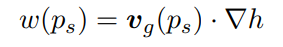

In [1]:
import xarray as xr
import numpy as np
import metpy.calc as mpcalc
import metpy.constants as mpconstants
from metpy.units import units
from scipy import ndimage

def cal_S(t,levels):
    te=t.loc[:,:,39:35,113.5:115.25]
    theta=te.copy()
    for L,pressure in enumerate(levels):
        theta[:,L]=mpcalc.potential_temperature(pressure*units.Pa,te[:,L]*units.degK)
    thetaa=theta.mean(['time','latitude','longitude'])
    ta=te.mean(['time','latitude','longitude'])
    S= -(mpconstants.Rd*ta/levels/thetaa)* mpcalc.first_derivative(f=thetaa,x=levels)
    return S.data.magnitude

def cal_sigma(t,q,levels):
    extent=[113.5,115.25,35,39]
    te=t.loc[:,:,39:35,113.5:115.25]
    qe=q.loc[:,:,39:35,113.5:115.25]
    rho,theta=te.copy(),te.copy()
    sigma=te[0,:,0,0].copy()
    for L,pressure in enumerate(levels):
        rho[:,L]=mpcalc.density(pressure*units.Pa,te[:,L]*units.degK,qe[:,L]*units('kg/kg'))
        theta[:,L]=mpcalc.potential_temperature(pressure*units.Pa,te[:,L]*units.degK)
    rhoa=rho.mean(['time','latitude','longitude'])
    thetaa=theta.mean(['time','latitude','longitude'])
    sigma=-1/rhoa/thetaa*mpcalc.first_derivative(f=thetaa,x=levels)
    return sigma.data

def cal_dynamicforcing(u,v,t,levels):
    T1=u.copy()
    for T in range(len(u)):
        for L,pressure in enumerate(levels):
            Qx,Qy=mpcalc.q_vector(u[T,L]*units('m/s'),v[T,L]*units('m/s'),t[T,L]*units('K'),pressure*units('Pa'),dx=dx,dy=dy)
            T1[T,L]=(-2)*mpcalc.divergence(Qx,Qy,dx=dx,dy=dy)
    return T1

def cal_earthrotationforcing(z,levels):
    T2=z.copy()
    for T in range(len(z)):
        ug,vg=z[0].copy(),z[0].copy()
        for L,pressure in enumerate(levels):
            ug[L],vg[L]=mpcalc.geostrophic_wind(z[T,L]*units('m^2/s^2'),dx=dx,dy=dy,latitude=np.deg2rad(lat_2d))
        for J in range(z.shape[2]):
            for I in range(z.shape[3]):
                T2[T,:,J,I]=f0*beta0*mpcalc.first_derivative(f=vg[:,J,I],x=levels)
    return T2

def cal_diabaticforcing(u,v,omg,t,time,levels,sigma):
    T3=t.copy()
    times=(time-time[0])/np.timedelta64(1,'s')
    for L,pressure in enumerate(levels):
        J=t[:,0].copy()
        J1,J2,J3=J.copy(),J.copy(),J.copy()
        for j in range(t.shape[2]):
            for i in range(t.shape[3]):
                J1[:,j,i]=mpcalc.first_derivative(f=t[:,L,j,i],x=times)
        for T in range(len(times)):
            J2[T]=mpcalc.advection(t[T,L],u[T,L],v[T,L],dx=dx,dy=dy)
        J3=-pressure/mpconstants.Rd*sigma[L]*omg[:,L]
        J=mpconstants.Cp_d*(J1+J2+J3.magnitude)
        for T in range(len(times)):
            T3[T,L]=-kappa/pressure*mpcalc.laplacian(J[T],deltas=[dx[1:,0],dy[0,1:]])
    return T3

def cal_boundaryomega(z,ts,ps,levels):
    omg,w=np.zeros(z.shape),z[:,0].copy()
    for T in range(len(z)):
        ugs,vgs=z[0,0].copy(),z[0,0].copy()
        ug,vg=z[0].copy(),z[0].copy()
        for L,pressure in enumerate(levels):
            Z = ndimage.gaussian_filter(z[T,L], sigma=3)
            ug[L],vg[L]=mpcalc.geostrophic_wind(Z*units('m^2/s^2'),dx=dx,dy=dy,latitude=np.deg2rad(lat_2d))
        for j in range(z.shape[2]):
            for i in range(z.shape[3]):
                ugs[j,i]=np.interp(ps[T,j,i],levels[::-1],ug[::-1,j,i])
                vgs[j,i]=np.interp(ps[T,j,i],levels[::-1],vg[::-1,j,i])
        h=xr.open_dataset('/home/jen/public/ETOPO1_Ice_g_gmt4.grd.nc')['z'][::-15,::15].loc[55.25:20,90:145]
        H = ndimage.gaussian_filter(h, sigma=3)
        ghy,ghx=mpcalc.gradient(H*units('m'),deltas=[dy,dx])
        w[T]=ugs*ghx+vgs*ghy
    omg[:,0]=mpcalc.vertical_velocity_pressure(w*units('m/s'),ps*units('Pa'),ts*units('K'))
    return omg

year='2021'
if year=='2016':
    stt,edt=17,47
    ps=xr.open_dataset('2016071820surfacept.nc')['sp'][stt:edt]
    ts=xr.open_dataset('2016071820surfacept.nc')['t2m'][stt:edt]
    data=xr.open_dataset('/home/jen/A_research_2206/AFinal/finaldata/2016071820.nc')
else:
    stt,edt=30,40
    ps=xr.open_dataset('2021071012surfacept.nc')['sp'][stt:edt]
    ts=xr.open_dataset('2021071012surfacept.nc')['t2m'][stt:edt]
    data=xr.open_dataset('/home/jen/A_research_2206/AFinal/finaldata/2021071012.nc')
    
u=data['u'].data[stt:edt,::-1]
v=data['v'].data[stt:edt,::-1]
omg=data['w'].data[stt:edt,::-1]
t=data['t'][stt:edt,::-1]
z=data['z'][stt:edt,::-1]
q=data['q'][stt:edt,::-1]

time=data['time'].data[stt:edt]   # event duration
levels=z['level'].data*100     # Pa
lon=data['longitude'].data
lat=data['latitude'].data
lon_2d,lat_2d=np.meshgrid(lon,lat)
dx,dy = mpcalc.lat_lon_grid_deltas(lon,lat)

###### constant
loclat=np.deg2rad(37)  #中心纬度
f0=2*mpconstants.omega*np.sin(loclat)
beta0=2*mpconstants.omega*np.cos(loclat)/mpconstants.Re
kappa=mpconstants.Rd/mpconstants.Cp_d
sigma=cal_sigma(t,q,levels)
S=cal_S(t,levels)    #static stability parameter 
######
t=t.data
z=z.data

T1=cal_dynamicforcing(u,v,t,levels)
T2=cal_earthrotationforcing(z,levels)
T3=cal_diabaticforcing(u,v,omg,t,time,levels,S)
omegaboundary=cal_boundaryomega(z,ts,ps,levels)


In [2]:
ds=xr.Dataset({
    'T1':(['time','level','lat','lon'],T1),
    'T2':(['time','level','lat','lon'],T2),
    'T3':(['time','level','lat','lon'],T3),
    'omegas':(['time','level','lat','lon'],omegaboundary),
    'S':(['level'],S),
    
}, 
      coords={
          'time':(['time'],time),
          'level':(['level'],levels),
          'lat':(['lat'],lat),
          'lon':(['lon'],lon),}
)
ds.to_netcdf(year+str(int(edt-stt))+'hT123_omegas_S.nc')

# invert

In [3]:
import xarray as xr
import numpy as np
from xinvert import invert_omega
year='202110'
ds=xr.open_dataset(year+'hT123_omegas_S.nc')

omegas=ds['omegas']
S=ds['S']
T1=ds['T1']

zero0=np.zeros((T1.shape))
z0=xr.DataArray(zero0, coords={
          'time':(['time'],T1['time'].data),
          'level':(['level'],T1['level'].data),
          'lat':(['lat'],T1['lat'].data),
          'lon':(['lon'],T1['lon'].data),})

iParams = {
    'BCs'      : ['fixed', 'fixed', 'fixed'],
    'tolerance': 1e-16,
}
mParams = {'N2':S,
          'f0':f0,
           'beta':beta0,
          }

omegatopo=invert_omega(z0, dims=['level', 'lat', 'lon'], icbc=omegas,iParams=iParams, mParams=mParams)
omegatopo.to_netcdf(year+'homegatopo.nc')
print('omegatopo over!')

var=['T1','T2','T3']
for V,vvar in enumerate(var):
    T=ds[vvar]
    omgt=invert_omega(T,dims=['level','lat','lon'],iParams=iParams,mParams=mParams)
    omgt.to_netcdf(year+'h'+vvar+'omega.nc')
    print('omega'+vvar+' over!')

{time: 2021-07-11T06:00:00} loops 1047 and tolerance is 0.000000e+00
{time: 2021-07-11T07:00:00} loops 1058 and tolerance is 0.000000e+00
{time: 2021-07-11T08:00:00} loops 1035 and tolerance is 0.000000e+00
{time: 2021-07-11T09:00:00} loops 1020 and tolerance is 0.000000e+00
{time: 2021-07-11T10:00:00} loops 1033 and tolerance is 0.000000e+00
{time: 2021-07-11T11:00:00} loops 1086 and tolerance is 0.000000e+00
{time: 2021-07-11T12:00:00} loops 1050 and tolerance is 0.000000e+00
{time: 2021-07-11T13:00:00} loops 1070 and tolerance is 0.000000e+00
{time: 2021-07-11T14:00:00} loops 1095 and tolerance is 0.000000e+00
{time: 2021-07-11T15:00:00} loops 1084 and tolerance is 0.000000e+00
omegatopo over!
{time: 2021-07-11T06:00:00} loops 5000 and tolerance is 6.946375e-11
{time: 2021-07-11T07:00:00} loops 5000 and tolerance is 1.090320e-09
{time: 2021-07-11T08:00:00} loops 5000 and tolerance is 3.821478e-10
{time: 2021-07-11T09:00:00} loops 5000 and tolerance is 3.783215e-10
{time: 2021-07-11T

##  combine

In [4]:
year='202110'
o1=xr.open_dataset(year+'hT1omega.nc')['inverted']
o2=xr.open_dataset(year+'hT2omega.nc')['inverted']
o3=xr.open_dataset(year+'hT3omega.nc')['inverted']
ot=xr.open_dataset(year+'homegatopo.nc')['inverted']

ds=xr.Dataset({
    'omega_dynamic':(['time','level','lat','lon'],o1.data),
    'omega_beta':(['time','level','lat','lon'],o2.data),
    'omega_diabatic':(['time','level','lat','lon'],o3.data),
    'omega_topographic':(['time','level','lat','lon'],ot.data),
}, 
      coords={
          'time':(['time'],o1['time'].data),
          'level':(['level'],o1['level'].data),
          'lat':(['lat'],o1['lat'].data),
          'lon':(['lon'],o1['lon'].data),}
)
ds.to_netcdf(year+'hQGomega_S.nc')


# draw event mean

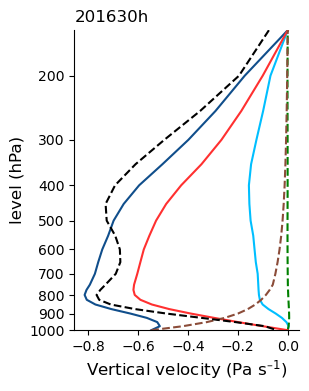

In [10]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import metpy.calc as mpcalc

year='201630'
if year=='201630':
    datar=xr.open_dataset('/home/jen/A_research_2206/AFinal/finaldata/2016071820.nc')
    stt,edt=17,47
else:
    datar=xr.open_dataset('/home/jen/A_research_2206/AFinal/finaldata/2021071012.nc')
    stt,edt=30,40
    
data=xr.open_dataset(year+'hQGomega_S.nc')
o1=data['omega_dynamic'].loc[:,:,39:35,113.5:115.25].mean(['time','lon','lat'])
o2=data['omega_beta'].loc[:,:,39:35,113.5:115.25].mean(['time','lon','lat'])
o3=data['omega_diabatic'].loc[:,:,39:35,113.5:115.25].mean(['time','lon','lat'])
ot=data['omega_topographic'].loc[:,:,39:35,113.5:115.25].mean(['time','lon','lat'])
oall=o1+o2+o3+ot
levels=data['level']/100
levelsr=datar['level']
omgr=datar['w'][stt:edt].loc[:,:,39:35,113.5:115.25].mean(['time','longitude','latitude'])

fig=plt.figure(figsize=(3,4))
f= fig.add_axes([0.22,0.15,0.75,0.75])
f.invert_yaxis()
f.set_yscale('symlog')
plt.yticks(np.arange(100,1100,100))
f.set_yticklabels([100,  200,  300,  400,  500,  600,700, 800, 900,1000])
plt.ylim(ymin=1000, ymax=150)
# plt.xlim(xmin=0, xmax=20)

f.spines['top'].set_color('none')
f.spines['right'].set_color('none')
plt.xlabel('Vertical velocity (Pa s$^{\endash 1}$)',x=0.5,labelpad=3,fontsize=12)
plt.ylabel('level (hPa)',y=0.5,labelpad=3,fontsize=12,rotation=90)

c5=plt.plot(oall,levels,color='#104E8B',label='$\omega_{QG}$')
c1=plt.plot(o1,levels,color='#00BFFF',label='$\omega_{Dyn}$')
c2=plt.plot(o2,levels,color='green',linestyle='--',label='$\omega_{Beta}$')

c3=plt.plot(o3,levels,color='#FF3030',label='$\omega_{Dia}$')

c4=plt.plot(ot,levels,color='#8B4C39',linestyle='--',label='$\omega_{Topo}$')
c5=plt.plot(omgr,levelsr,color='black',linestyle='--',label='$\omega$')
# plt.legend()

plt.title(year+'h',loc='left')
plt.savefig('eventaveraged'+year+'.png',dpi=650)